# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

***Описание данных***

Данные лежат в папке `/datasets/image_search/`.

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

In [ ]:
!wget -q https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip
!unzip -q dsplus_integrated_project_4.zip


data = DATA_PATH = '/content/to_upload'

In [ ]:
!pip install -q transformers torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 21.5 MB/s eta 0:00:00


In [ ]:
import pickle
import re
from os.path import exists, isfile, join

import nltk
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from PIL import Image

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tqdm.notebook import tqdm, trange

import os
np.random.seed(45)

import torch
torch.manual_seed(45)
import torchvision
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.io import read_image

from sklearn.metrics import mean_absolute_error
from torch.autograd import Variable

## Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


In [ ]:
train_path = join(data, 'train_images')
test_path = join(data, 'test_images')

In [ ]:
df_train = pd.read_csv(data+'/train_dataset.csv')

In [ ]:
df_train.head()

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


In [ ]:
df_train.describe()

,image,query_id,query_text
count,5822,5822,5822
unique,1000,977,977
top,3364151356_eecd07a23e.jpg,2600867924_cd502fc911.jpg#2,"Two dogs , one brown and white and one black a..."
freq,10,34,34


Как видно из таблицы, в тренировочном датасете у нас 1000 изображений, имеющих 5822 связей с описаниями, 977 из которых уникальны.

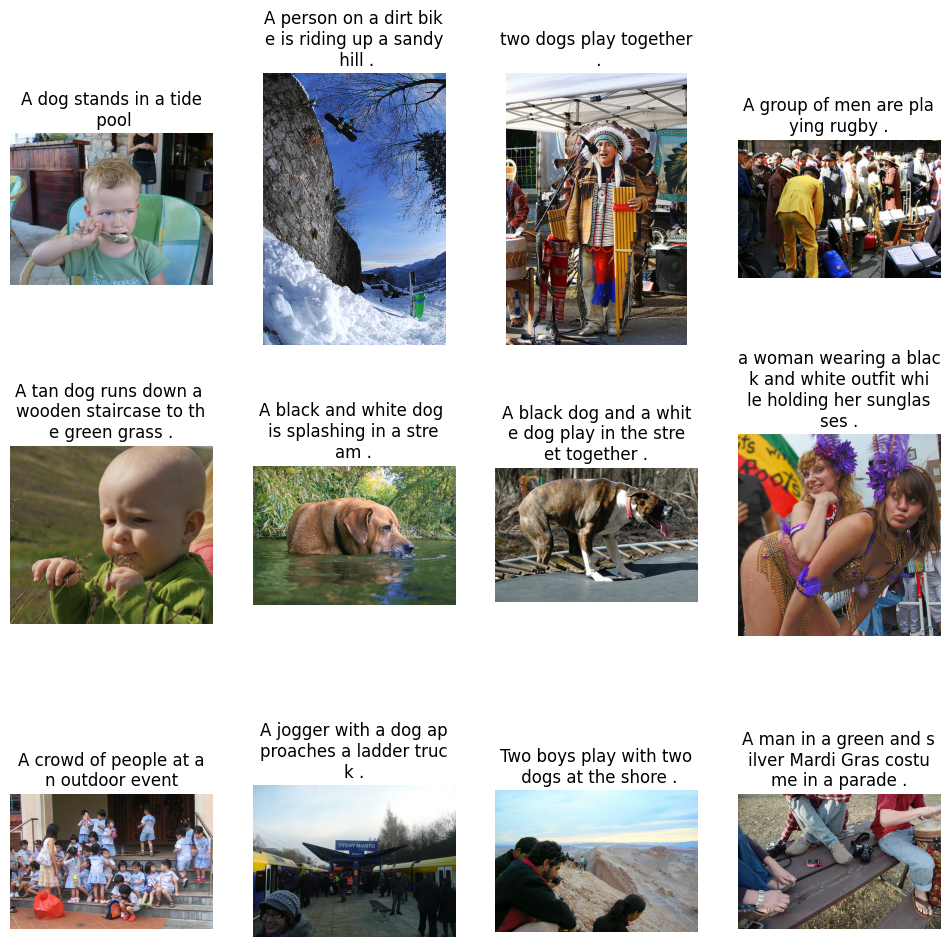

In [ ]:
rows = 3
columns = 4

fig = plt.figure(figsize=(12, 12))
count = 1
for _, file, _, query_text in df_train.sample(rows * columns).itertuples():
    img = Image.open(join(train_path, file))
    fig.add_subplot(rows, columns, count)
    count += 1
    plt.imshow(np.array(img))
    plt.axis('off')
    chunks, chunk_size = len(query_text), 22
    plt.title(
        '\n'.join(
            [query_text[i : i + chunk_size] for i in range(0, chunks, chunk_size)]))

Для удобства дальнейшей работы переименуем столбец query_id в annotation_id:

In [ ]:
df_train = df_train.rename(columns={'query_id': 'annotation_id'})

Посмотрим экспертные оценки точности анотирования фото:

In [ ]:
expert_annotations = pd.read_csv(
    join(data, 'ExpertAnnotations.tsv'), sep='\t', header=None)

In [ ]:
expert_annotations.columns = ['image', 'annotation_id', 'score_1', 'score_2', 'score_3']
expert_annotations.head()

,image,annotation_id,score_1,score_2,score_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


In [ ]:
expert_annotations.describe()

,score_1,score_2,score_3
count,5822.000000,5822.000000,5822.000000
mean,1.436620,1.624356,1.881999
std,0.787084,0.856222,0.904087
min,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000
50%,1.000000,1.000000,2.000000
75%,2.000000,2.000000,2.000000
max,4.000000,4.000000,4.000000


Видно, что эксперты не высокого мнения о качестве разметки:
- медиана у двух экспертов из 3 равна 1, т.е. эксперты считают, что 50% изображений и их описаний совершенно не соответствуют друг другу
- лишь один эксперт считает, что в 50% случаев запрос содержит элементы описания изображения, но в целом фото тексту не соответствует

Посмотрим данные по соответствию изображения и описания, полученные с помощью краудсорсинга:

In [ ]:
crowd_annotations = pd.read_csv(
    join(data, 'CrowdAnnotations.tsv'), sep='\t', header=None)

In [ ]:
crowd_annotations.columns = ['image', 'crowd_id', 'ratio_ppl_plus', 'count_ppl_plus', 'count_ppl_minus']
crowd_annotations.head()

,image,crowd_id,ratio_ppl_plus,count_ppl_plus,count_ppl_minus
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


Теперь посмотрим на тестовые данные:

In [ ]:
test_queries = pd.read_csv(data+'/test_queries.csv', sep='|', index_col=0)

In [ ]:
test_queries.head()

,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


In [ ]:
test_queries.describe()

,query_id,query_text,image
count,500,500,500
unique,500,500,100
top,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
freq,1,1,5


- В тестовой выборке 100 фото, которым соответсвует 500 уникальных описаний
- Получается, что каждой фотографии соответствует в точности 5 уникальных описаний.

In [ ]:
test_images = pd.read_csv(data + '/test_images.csv')

In [ ]:
test_images.head()

,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg


In [ ]:
test_images.describe()

,image
count,100
unique,100
top,3356748019_2251399314.jpg
freq,1


### Вывод
Были загружены:

- тренировочный датасет из 5822 пар изображение-описание
- набор оценок экспертов, которые определяли соответствие описания изображдению, это те же 5822 записи фото-описание
- набор тестовых запросов и изображений, на которых предстоит проверить качество работы обученных моделей.

## Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

Как очевидно из задания, поставленная задача распадается на две:

- нужно на основе описаний в тренировочном датасете и оценок экспертов выявить неприемлемый контент и удалить его из обучающей выборки;
- нужно убрать пары описание-фото, которые не соответствуют друг другу, чтобы не обучать модель на заведоми неправильных сочетаниях

На оставшейся выборке обучить модель, которая будет сопоставлять изображения заданным описаниям

### Построение сводной экспертной оценки

Эксперта три, но оценка нужна одна, поэтому используем метод голосования:
- если 2 эксперта поставили одинаковую оценку, она считается верной
- если все три оценки разные, такое описание отбрасывается

Построим функцию, которая принимает тройку оценок и возвращает ту, что совпадает хотя бы у двоих.

Иначе возвращает "None":

In [ ]:
def voting(v1, v2, v3):
    if v1 == v2 or v1 == v3:
        return v1
    elif v2 == v3:
        return v2
    else:
        return None

In [ ]:
expert_annotations['experts'] = expert_annotations.apply(
    lambda x: voting(x['score_1'], x['score_2'], x['score_3']), axis=1)

Удаляем несогласованные оценки:

In [ ]:
expert_annotations = expert_annotations.dropna(subset=['experts'])

In [ ]:
expert_annotations.head()

,image,annotation_id,score_1,score_2,score_3,experts
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,1.0
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,1.0
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,1.0
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,2.0
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,1.0


Масштабируем сводную оценку:

In [ ]:
mm_scaler = MinMaxScaler()

In [ ]:
expert_annotations["experts"] = mm_scaler.fit_transform(expert_annotations[["experts"]])

<ipython-input-26-d4df9b0794d3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expert_annotations["experts"] = mm_scaler.fit_transform(expert_annotations[["experts"]])


Нас интересуют только более-менее соответствующие друг другу изображения и описания, поэтому отбросим сочетания, для которым экспертная оценка ниже 0,5:

In [ ]:
expert_annotations = expert_annotations.drop(
    expert_annotations[expert_annotations["experts"] < 0.5].index, axis=0)

In [ ]:
expert_annotations.shape[0]

803

Получается, правильных описаний к фото у нас всего 803. Очень мало. Попробуем снизить планку точности оценок, но это чревато ошибками сопоставления.

Наложим полученные экспертные оценки на тренировочный датасет:

In [ ]:
df_train = (df_train.set_index(['image', 'annotation_id'])
    .join(expert_annotations.set_index(['image', 'annotation_id'])[['experts']],
        how='inner',).reset_index())

In [ ]:
df_train

,image,annotation_id,query_text,experts
0,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1.000000
1,2718495608_d8533e3ac5.jpg,2718495608_d8533e3ac5.jpg#2,A girl wearing a yellow shirt and sunglasses s...,1.000000
2,700884207_d3ec546494.jpg,2718495608_d8533e3ac5.jpg#2,A girl wearing a yellow shirt and sunglasses s...,0.666667
3,2370481277_a3085614c9.jpg,3545652636_0746537307.jpg#2,A young boy dressed in a red uniform kicks the...,0.666667
4,2913965136_2d00136697.jpg,3545652636_0746537307.jpg#2,A young boy dressed in a red uniform kicks the...,0.666667
...,...,...,...,...
798,3507076266_8b17993fbb.jpg,3507076266_8b17993fbb.jpg#2,Man in brown jacket leading black horse,1.000000
799,542317719_ed4dd95dc2.jpg,542317719_ed4dd95dc2.jpg#2,A smiling child slides down a slippery tube slide,1.000000
800,758921886_55a351dd67.jpg,542317719_ed4dd95dc2.jpg#2,A smiling child slides down a slippery tube slide,1.000000
801,396360611_941e5849a3.jpg,2162564553_96de62c7e6.jpg#2,A shirtless man in a pink hat stands on a rock...,0.666667


### Лемматизация описаний

Лемматизируем описания фотографий, применим к леммам векторайзер:

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
lemmatizer = WordNetLemmatizer()

Для дальнейшей работы тексты нужно лемматизировать и токенизировать. Иногда для правильной лемматизации лемматезатору требуется уточнение, какой частью речи является слова. Эту информацию также можно получить средствами nltk:

Если слово не является существительным, прилагательным, гаголом или наречием, назначаем его существительным:

In [ ]:
def pos_tag(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {
        'J': wordnet.ADJ,
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV,
    }
    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
%%time
df_train['lemm_query'] = df_train['query_text'].apply(
    lambda x: " ".join(
        [lemmatizer.lemmatize(w, pos_tag(w)) for w in nltk.word_tokenize(x)]))

CPU times: user 4.16 s, sys: 251 ms, total: 4.41 s
Wall time: 7.91 s


In [ ]:
df_train['lemm_query'] = df_train['lemm_query'].apply(
    lambda x: (' '.join(re.sub(r'[^a-zA-Z ]', ' ', x).split()).lower()))

#### Удаление проблемного контента

- cоставим список слов, используемых в английском для обозначения детей и подростков
- напишем функцию, которая будет искать эти слова в лемматезированных текстах

In [ ]:
child_stop = [
    "boy",
    "girl",
    "child",
    "baby",
    "kid",
    "babe",
    "infant",
    "teenager",
    "teeny",
    "juvenile",
    "teener",
    "stripling"]

- Последовательно ищем слова из стоп-листа child_stop в заданном тексте text.
- Возвращаем True, если нашлось хотя бы одно слово

In [ ]:
def chld_text(text: str) -> bool:
    res = False
    for w in child_stop:
        res |= text.lower().find(w) > -1
    return res

In [ ]:
df_train['child'] = df_train.apply(
    lambda x: chld_text(x['lemm_query']), axis=1)

Удаляем найденные изображения с детьми:
- составляем список изображений, где обнаружены дети
- удаляем все записи, содержащие эти изображения

In [ ]:
child_images = set(df_train[df_train['child'] == True]['image'])

In [ ]:
df_train = df_train.drop(
    df_train[df_train['image'].isin(child_images)].index, axis=0)

In [ ]:
df_train.shape

(646, 6)

Осталось всего 646 описания

#### Разбиение тренировочного множества на тренировочную и валидационную выборки

Прежде чем векторизовать набор описаний, отделим валидационную выборку: её не следует использовать при эмбеддинге.

Т.к у нас одному изображению соответствует несколько описаний, то случайное разделение может привести к тому, что одно и тоже фото может оказаться и в тестовой и валидационой, что недопустимо

In [ ]:
df_train.head()

,image,annotation_id,query_text,experts,lemm_query,child
5,1425069308_488e5fcf9d.jpg,1425069308_488e5fcf9d.jpg#2,A white dog jumps to catch a blue ball in a li...,1.000000,a white dog jump to catch a blue ball in a liv...,False
8,1897025969_0c41688fa6.jpg,2398605966_1d0c9e6a20.jpg#2,Two long-haired puppy dogs have a romp in the ...,0.666667,two long haired puppy dog have a romp in the snow,False
9,2340206885_58754a799a.jpg,2398605966_1d0c9e6a20.jpg#2,Two long-haired puppy dogs have a romp in the ...,0.666667,two long haired puppy dog have a romp in the snow,False
10,317383917_d8bfa350b6.jpg,2398605966_1d0c9e6a20.jpg#2,Two long-haired puppy dogs have a romp in the ...,0.666667,two long haired puppy dog have a romp in the snow,False
11,3223224391_be50bf4f43.jpg,2398605966_1d0c9e6a20.jpg#2,Two long-haired puppy dogs have a romp in the ...,0.666667,two long haired puppy dog have a romp in the snow,False


In [ ]:
gss = GroupShuffleSplit(n_splits=1, train_size=0.75, random_state=42)
train_indices, test_indices = next(
    gss.split(
        X=df_train.drop(columns=['annotation_id']),
        y=df_train['annotation_id'],
        groups=df_train['image']))
train_df, valid_df = df_train.iloc[train_indices], df_train.iloc[test_indices]

In [ ]:
train_df.head()

,image,annotation_id,query_text,experts,lemm_query,child
5,1425069308_488e5fcf9d.jpg,1425069308_488e5fcf9d.jpg#2,A white dog jumps to catch a blue ball in a li...,1.000000,a white dog jump to catch a blue ball in a liv...,False
8,1897025969_0c41688fa6.jpg,2398605966_1d0c9e6a20.jpg#2,Two long-haired puppy dogs have a romp in the ...,0.666667,two long haired puppy dog have a romp in the snow,False
9,2340206885_58754a799a.jpg,2398605966_1d0c9e6a20.jpg#2,Two long-haired puppy dogs have a romp in the ...,0.666667,two long haired puppy dog have a romp in the snow,False
10,317383917_d8bfa350b6.jpg,2398605966_1d0c9e6a20.jpg#2,Two long-haired puppy dogs have a romp in the ...,0.666667,two long haired puppy dog have a romp in the snow,False
12,2207244634_1db1a1890b.jpg,3119076670_64b5340530.jpg#2,Snowboarder in the air performing a stunt .,0.666667,snowboarder in the air perform a stunt,False


## Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.

Опыт спринта, посвящённого обработке естественных языков, говорит, что TF-IDF и word2vec справляются примерно одинаково с некоторым перевесом в пользу TF-IDF. BERT, может и хороша, но без мощной видекарты там нечего ловить. Используем для векторизации модель TF-IDF. Для эмбеддинга будем использовать train_df

In [ ]:
tfvect_short = TfidfVectorizer(stop_words=list(stop_words))

In [ ]:
tf_matrix_short = tfvect_short.fit_transform(train_df['lemm_query'])

In [ ]:
tf_matrix_short.todense().shape

(493, 432)

In [ ]:
tfvect = TfidfVectorizer(stop_words=list(stop_words), ngram_range=(1, 2))

In [ ]:
tf_matrix = tfvect.fit_transform(train_df['lemm_query'])

In [ ]:
tf_matrix.todense().shape

(493, 1338)

Использование даже двусловных н-грамм приводит к увеличению размерности вектора в 3 с лишним раза. С одной стороны, размер нашего датасета весьма скромен и его может не хватить на обучение модели большой размерности. С другой опыт использования эмбеддингов текстов говорит о том, что н-граммы положительно влияют на качество сопоставления текстов

In [ ]:
torch.FloatTensor(tf_matrix.todense()).shape

torch.Size([493, 1338])

In [ ]:
train_df['query_vector'] = tf_matrix.todense().tolist()

<ipython-input-53-425b1708da1d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['query_vector'] = tf_matrix.todense().tolist()


In [ ]:
train_df['query_vector'] = train_df['query_vector'].apply(
    lambda x: torch.tensor(np.array(x, dtype=np.float)))

<ipython-input-54-9a949cf34391>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lambda x: torch.tensor(np.array(x, dtype=np.float)))
<ipython-input-54-9a949cf34391>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['query_vector'] = train_df['query_vector'].apply(


Теперь на основе обученной модели векторизуем валидационные описания:

In [ ]:
tf_matrix = tfvect.transform(valid_df['lemm_query'])
valid_df['query_vector'] = tf_matrix.todense().tolist()

valid_df['query_vector'] = valid_df['query_vector'].apply(
    lambda x: torch.tensor(np.array(x, dtype=np.float)))

<ipython-input-55-3b496a99cbca>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df['query_vector'] = tf_matrix.todense().tolist()
<ipython-input-55-3b496a99cbca>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lambda x: torch.tensor(np.array(x, dtype=np.float)))
<ipython-input-55-3b496a99cbca>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

## Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную.

In [ ]:
transformationForCNNInput = transforms.Compose([transforms.Resize((224,224))])
for imageName in os.listdir(train_path):
    I = Image.open(os.path.join(train_path, imageName))
    newI = transformationForCNNInput(I)

    if "exif" in I.info:
        exif = I.info['exif']
        newI.save(os.path.join(train_path, imageName), exif=exif)
    else:
        newI.save(os.path.join(train_path, imageName))

In [ ]:
class Img2VecResnet18():
    def __init__(self):
        self.device = torch.device("cpu")
        self.numberFeatures = 512
        self.modelName = "resnet-18"
        self.model, self.featureLayer = self.getFeatureLayer()
        self.model = self.model.to(self.device)
        self.model.eval()
        self.toTensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    def getFeatureLayer(self):
        cnnModel = models.resnet18(pretrained=True)
        layer = cnnModel._modules.get('avgpool')
        self.layer_output_size = 512

        return cnnModel, layer
    def getVec(self, img):
        image = self.normalize(self.toTensor(img)).unsqueeze(0).to(self.device)
        embedding = torch.zeros(256, self.numberFeatures, 1, 1)
        def copyData(m, i, o): embedding.copy_(o.data)
        h = self.featureLayer.register_forward_hook(copyData)
        self.model(image)
        h.remove()
        return embedding.numpy()[0, :, 0, 0]

In [ ]:
image_vec = pd.DataFrame(
    index=df_train['image'].unique(), columns=['image_vector'])

In [ ]:
img2vec = Img2VecResnet18()
allVectors = {}
for image in tqdm(image_vec.index):
    I = Image.open(join(train_path, image))
    vec = img2vec.getVec(I)
    allVectors[image] = torch.tensor(vec)

    I.close()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 87.1MB/s]


  0%|          | 0/372 [00:00<?, ?it/s]

In [ ]:
image_vec = pd.DataFrame(
    index=df_train['image'].unique(), columns=['image_vector'])

In [ ]:
c = 0
for i in allVectors.keys():
  image_vec['image_vector'][c] = allVectors.get(i)
  c += 1

In [ ]:
image_vec =image_vec.reset_index().rename(columns={'index': 'image'})

In [ ]:
train_df = train_df.merge(image_vec, on='image', how='left')
valid_df = valid_df.merge(image_vec, on='image', how='left')

### Вывод
1. Была построена единая экспертная оценка. Отброшены описания, недостоверные с точки зрения экспертов.
1. Удалено около 500 изображений, в описаниях которых упоминались дети и подростки.
1. С помощью TF-IDF были векторизованы описания изображений в тренировочном датасете. Размерность полученных векторов - 1528.
1. С помощью предобученной свёрточной нейросети ResNet50 были векторизованы изображения. Размерность полученных векторов совпадает с размерностью векторов описаний.

## Обучение модели предсказания соответствия

Пришло время обучить модели, которые бы ставили в соответствие "близким" описаниям "близкие" фото. В качестве моделей исполльзуем линейную регрессию и нейросеть.

Начнём с линейной регрессии

In [ ]:
X_train = train_df[['annotation_id', 'query_vector']]
y_train = train_df[['image', 'image_vector']]

In [ ]:
X_val = valid_df[['annotation_id', 'query_vector']]
y_val = valid_df[['image', 'image_vector']]

In [ ]:
X_train_tensor = torch.cat(tuple(X_train.query_vector),dim=0)
X_train_tensor = torch.reshape(X_train_tensor, (493,1,1338))

In [ ]:
X_val_tensor = torch.cat(tuple(X_val.query_vector),dim=0)
X_val_tensor = torch.reshape(X_val_tensor, (153,1,1338))

In [ ]:
y_train_tensor = torch.cat(tuple(y_train.image_vector),dim=0)
y_train_tensor = torch.reshape(y_train_tensor, (493,1,512))

In [ ]:
y_val_tensor = torch.cat(tuple(y_val.image_vector),dim=0)
y_val_tensor = torch.reshape(y_val_tensor, (153,1,512))

### Линейная регрессия

Обучим линейную регрессию средствами библиотеки Pytorch:
- создадим рандомные значения для вектора весов W и смещения b

In [ ]:
# nn.Module - базовый класс для всех нейронных сетей PyTorch
# Любая создаваемая модель должна наследовать от данного класса
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        # инициализация параметров модели (некоторые случайные значения)

        # requires_grad=True означает, что PyTorch будет использовать градиентный
        # спуск для вычисления значения параметра
        self.weights = nn.Parameter(torch.autograd.Variable(torch.rand(1338, 512, dtype=torch.float64)))
        self.bias = nn.Parameter(torch.autograd.Variable(torch.rand(1, 512, dtype=torch.float64)))

    # метод определяет, каким образом зная признаки находится значение таргета
    def forward(self, x: torch.Tensor) -> torch.Tensor:
      return torch.add(torch.matmul(x, self.weights), self.bias)

In [ ]:
model = LinearRegressionModel() # Создание модели

In [ ]:
# Зададим функцию потерь
loss_fn = nn.L1Loss()

# Зададим оптимизатор
optimizer = torch.optim.Adam(params=model.parameters(), # Параметры для оптимизации
                             lr=0.001) # Чем больше значение learning rate - тем быстрее учится модель
                                       # но может не достигнуть глобального минимума (и наоборот)

In [ ]:
torch.manual_seed(42)

# Сколько раз модель будет обучаться на входных данных
epochs = 600

# Создадим вспомогательные списки для сохранения результатов обучения
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
      ### Тренировка модели
  model.train()

      # 1. Получаем предсказания (скрыто вызывается метод .forward())

  y_pred = model(X_train_tensor)

      # 2. Вычисление функции потерь - среднеквадратичного отклонения
  loss = loss_fn(y_pred, y_train_tensor)

      # 3. Важно отметить, что нам нужно очистить градиенты, чтобы они не накапливались в течение эпох и
      # не искажали модель. Это достигается путем вызова функции zero_grad() в оптимизаторе для каждой эпохи.
  optimizer.zero_grad()

      # 4. Вычисление градиента
  loss.backward()

      # 5. Очередной шаг спуска
  optimizer.step()
  with torch.inference_mode():
      # 1. Предсказываем значения на тестовых данных
    test_pred = model(X_val_tensor)

      # 2. Вычисляем значения фукнции потерь
    test_loss = loss_fn(test_pred, y_val_tensor)

          # Выводим результаты
    if epoch % 25 == 0:
      print("Epoch: {:3d} | MAE Train Loss: {:.3f} | MAE Test Loss: {:.3f}".format(epoch, loss, test_loss))
      epoch_count.append(epoch)
      train_loss_values.append(loss.detach().numpy())
      test_loss_values.append(test_loss.detach().numpy())


Epoch:   0 | MAE Train Loss: 1.322 | MAE Test Loss: 1.187
Epoch:  25 | MAE Train Loss: 1.242 | MAE Test Loss: 1.124
Epoch:  50 | MAE Train Loss: 1.164 | MAE Test Loss: 1.064
Epoch:  75 | MAE Train Loss: 1.089 | MAE Test Loss: 1.008
Epoch: 100 | MAE Train Loss: 1.017 | MAE Test Loss: 0.956
Epoch: 125 | MAE Train Loss: 0.949 | MAE Test Loss: 0.907
Epoch: 150 | MAE Train Loss: 0.884 | MAE Test Loss: 0.863
Epoch: 175 | MAE Train Loss: 0.822 | MAE Test Loss: 0.822
Epoch: 200 | MAE Train Loss: 0.764 | MAE Test Loss: 0.786
Epoch: 225 | MAE Train Loss: 0.711 | MAE Test Loss: 0.753
Epoch: 250 | MAE Train Loss: 0.661 | MAE Test Loss: 0.724
Epoch: 275 | MAE Train Loss: 0.615 | MAE Test Loss: 0.699
Epoch: 300 | MAE Train Loss: 0.573 | MAE Test Loss: 0.677
Epoch: 325 | MAE Train Loss: 0.534 | MAE Test Loss: 0.659
Epoch: 350 | MAE Train Loss: 0.500 | MAE Test Loss: 0.643
Epoch: 375 | MAE Train Loss: 0.469 | MAE Test Loss: 0.631
Epoch: 400 | MAE Train Loss: 0.442 | MAE Test Loss: 0.620
Epoch: 425 | M

Регрессия обучена. Теперь мы можем преобразовывать вектора описаний в вектора изображений и подбирать изображения максимально близкие к запросам. Для этого нужно написать функцию вычисляющую расстояние между двумя векторами. После этого останется только выбрать наиболее близкие вектора. Но перед этим нужно проверить качество прогноза (преобразования) на валидационной выборке.

Вычисляем  расстояние между векторами:

In [ ]:
def vec_distance(A: torch.Tensor, B: torch.Tensor) -> float:
    return torch.linalg.norm(B - A).detach().tolist()

Ищем в заданной серии ivecs lim векторов, наиболее близких к запросу query_vector. Функция возвращает имена файлов:

In [ ]:
def find_image_LR(query_vector, ivecs, lim=3):
    iv = model(query_vector)
    df = ivecs.copy()
    for i in df.index:
        df.loc[i, 'dist'] = vec_distance(iv, df.loc[i, 'image_vector'])
    return df.sort_values(by='dist')['image'].unique()[:lim]

Выводит фото из списка images, соответсвующие запросу query:

In [ ]:
def show_images(query, images, path=train_path, rows=1, columns=3):
    fig = plt.figure(figsize=(12, 12))
    print(query)
    count = 1
    for file in images:
        img = Image.open(join(path, file))
        fig.add_subplot(rows, columns, count)
        count += 1
        plt.imshow(np.array(img))
        plt.axis('off')

Соберём для удобства предыдущие функции в одну:
- принимает индекс в валидационной выборке
- извлекает из неё запрос и его вектор
- строит прогноз
- выводит результат

In [ ]:
def predict_LR(idx):
    qv = X_val.loc[idx, 'query_vector']
    qt = valid_df[valid_df['annotation_id'] == X_val.loc[idx, 'annotation_id']]['query_text'].iloc[0]
    images = find_image_LR(qv, y_val)
    show_images(qt, images)

A dog in a grassy field , looking up .


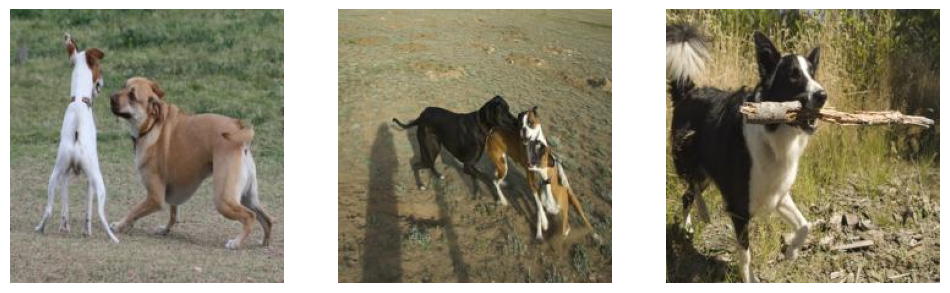

In [ ]:
predict_LR(30)

A little dog running on sand .


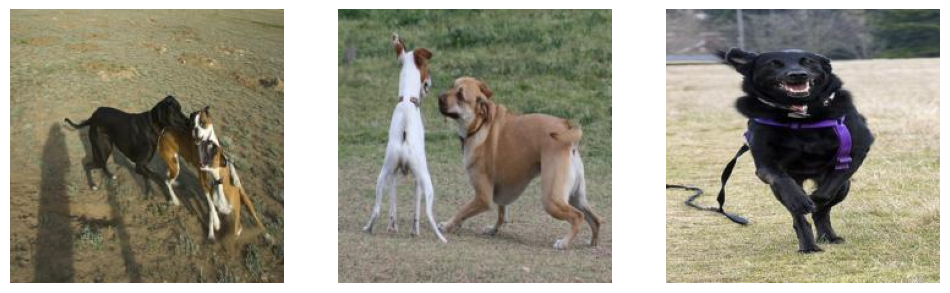

In [ ]:
predict_LR(140)

### Вывод

- Случайные выборки из валидационной выборки показывают, что линейная регрессия в целом справляется с работой: она не попадает в детали, но в целом не промахивается совсем уж сильно.

### Нейронная сеть

Обучим сравнительно простую нейросеть:
- Нейросеть не принимает на вход трёхмерные тензоры с элементами типа float64, так что преобразуем входные и выходные вектора в двумерные тензоры float32

In [ ]:
X_train_tensor = torch.tensor(X_train_tensor,dtype=torch.float32)

<ipython-input-80-188c6b536ad1>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train_tensor,dtype=torch.float32)


In [ ]:
X_val_tensor = torch.tensor(X_val_tensor,dtype=torch.float32)

<ipython-input-81-666af86723e4>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tensor = torch.tensor(X_val_tensor,dtype=torch.float32)


In [ ]:
y_train_tensor = torch.tensor(y_train_tensor,dtype=torch.float32)

<ipython-input-82-f75c6ecb8610>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor,dtype=torch.float32)


In [ ]:
y_val_tensor = torch.tensor(y_val_tensor,dtype=torch.float32)

<ipython-input-83-6c13de2aa3ef>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val_tensor = torch.tensor(y_val_tensor,dtype=torch.float32)


In [ ]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_hidden_neurons_4, n_out_neurons):
            super(Net, self).__init__()

            self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
            self.act1 = nn.ReLU()
            self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
            self.act2 = nn.ReLU()
            self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
            self.act3 = nn.ReLU()
            self.fc4 = nn.Linear(n_hidden_neurons_3, n_hidden_neurons_4)
            self.act4 = nn.ReLU()
            self.fc5 = nn.Linear(n_hidden_neurons_4, n_out_neurons)
            self.act5 = nn.Sigmoid()

            nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc3.weight, mode='fan_in', nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc4.weight, mode='fan_in', nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc5.weight, mode='fan_in', nonlinearity='sigmoid')

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.fc4(x)
        x = self.act4(x)
        x = self.fc5(x)
        x = self.act5(x)

        return x

In [ ]:
def my_loss(output, target):
        delta = (output - target)
        total_loss = (delta ** 2).sum(axis=1)
        mean_loss = torch.mean(total_loss)
        return mean_loss

In [ ]:
n_in_neurons = 1338
n_hidden_neurons_1 = 512
n_hidden_neurons_2 = 256
n_hidden_neurons_3 = 128
n_hidden_neurons_4 = 512
n_out_neurons = 512


net = Net(n_in_neurons,
          n_hidden_neurons_1,
          n_hidden_neurons_2,
          n_hidden_neurons_3,
          n_hidden_neurons_4,
          n_out_neurons)

optimizer2 = torch.optim.Adam(net.parameters(),
                             lr=.001)

optimizers = [optimizer2]

loss = nn.MSELoss()

In [ ]:
num_epochs = 600

for optimizer in optimizers:
    optimizer_rmse = []
    print(f'Оптимизатор {optimizer}:')

    for epoch in range(num_epochs):
        net.train()
        order = np.random.permutation(len(X_train_tensor))

        preds = net.forward(X_train_tensor)

        loss_value = loss(preds, y_train_tensor)

        loss_value.backward()

        optimizer.step()

        if epoch % 50 == 0 or epoch == num_epochs - 1:
            with torch.no_grad():
                net.eval()
                test_preds = net.forward(X_val_tensor)
                ans = round(float(torch.sqrt(loss(test_preds, y_val_tensor))), 2)
                print(f'Метрика RMSE на {epoch} итерации =', ans)
                optimizer_rmse.append(ans)
    print()
    print(f'Лучшая метрика RMSE = {min(optimizer_rmse)} обнаружена на {optimizer_rmse.index(min(optimizer_rmse))} эпохе')
    print(f'Средняя метрика RMSE = {round(np.mean(optimizer_rmse), 2)}')
    print('---------------------------------------------------------------------------------------------', '\n')

Оптимизатор Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
):
Метрика RMSE на 0 итерации = 0.95
Метрика RMSE на 50 итерации = 0.89
Метрика RMSE на 100 итерации = 0.89
Метрика RMSE на 150 итерации = 0.89
Метрика RMSE на 200 итерации = 0.89
Метрика RMSE на 250 итерации = 0.89
Метрика RMSE на 300 итерации = 0.89
Метрика RMSE на 350 итерации = 0.89
Метрика RMSE на 400 итерации = 0.89
Метрика RMSE на 450 итерации = 0.89
Метрика RMSE на 500 итерации = 0.89
Метрика RMSE на 550 итерации = 0.89
Метрика RMSE на 599 итерации = 0.89

Лучшая метрика RMSE = 0.89 обнаружена на 1 эпохе
Средняя метрика RMSE = 0.89
--------------------------------------------------------------------------------------------- 



In [ ]:
def find_image_NN(query_vector, ivecs, lim=3):
    iv = net.forward(query_vector)
    df = pd.DataFrame(ivecs)
    for i in df.index:
        df.loc[i, 'dist'] = vec_distance(iv, df.loc[i, 'image_vector'])
    return df.sort_values(by='dist')['image'].unique()[:lim]

In [ ]:
def predict_NN(idx, df=y_val):
    qv = X_val.loc[idx, 'query_vector']
    qv = torch.tensor(qv,dtype=torch.float32)
    qt = valid_df[valid_df['annotation_id'] == X_val.loc[idx, 'annotation_id']]['query_text'].iloc[0]
    images = find_image_NN(qv, df)
    show_images(qt, images)

A dog in a grassy field , looking up .


<ipython-input-89-08e6f617d3fa>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  qv = torch.tensor(qv,dtype=torch.float32)


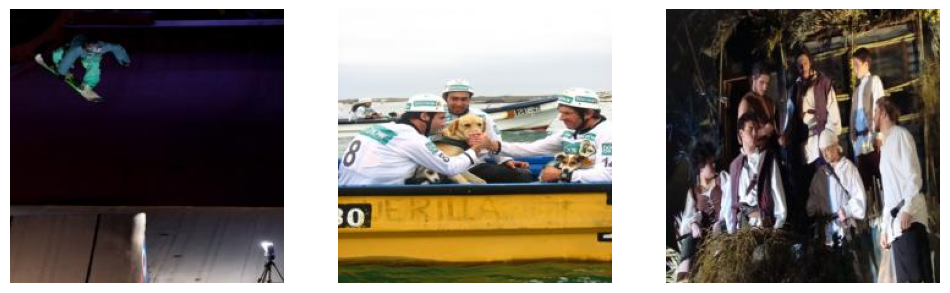

In [ ]:
predict_NN(30)

### Вывод

Нейросеть справлсяется с данной задачей хуже чем линейная регрессия, выберем линейную регрессию и протестируем ее.

## Тестирование модели

Заключительный этап - это тестирование лучше модели на новых данных из тестовой выборки.

In [ ]:
test_images['image_vector'] = ''

In [ ]:
img2vec = Img2VecResnet18()
allVectors = {}
for image in tqdm(test_images.image):
    I = Image.open(join(test_path, image))
    vec = img2vec.getVec(I)
    allVectors[image] = torch.tensor(vec)

    I.close()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
c = 0
for i in allVectors.keys():
  test_images['image_vector'][c] = allVectors.get(i)
  c += 1

In [ ]:
test_queries['lemm_query'] = test_queries['query_text'].apply(lambda x: " ".join(
        [lemmatizer.lemmatize(w, pos_tag(w)) for w in nltk.word_tokenize(x)]))

In [ ]:
tf_matrix_test = tfvect.transform(test_queries['lemm_query'])
test_queries['query_vector'] = tf_matrix_test.todense().tolist()
test_queries['query_vector'] = test_queries['query_vector'].apply(
    lambda x: torch.tensor(np.array(x, dtype=np.float)))

<ipython-input-95-4394cc6cf3b6>:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lambda x: torch.tensor(np.array(x, dtype=np.float)))


In [ ]:
def lemm(x):
    return " ".join([lemmatizer.lemmatize(w, pos_tag(w)) for w in nltk.word_tokenize(x)])

In [ ]:
def pred_lr_test(text, ivecs=test_images, lim=3):
    if len(set(text.split()) & set(child_stop)) > 0:
      print ('This image is unavailable in your country in compliance with local laws')
    else:
      lemm_text = lemm(text)
      vector_from_text = tfvect.transform([lemm_text]).todense()
      th_vect = torch.tensor(vector_from_text,dtype=torch.float64)
      vec = model(th_vect)
      df = pd.DataFrame(ivecs)
      for i in df.index:
        df.loc[i, 'dist'] = vec_distance(vec, df.loc[i, 'image_vector'])
      images = df.sort_values(by='dist')['image'].unique()[:lim]
      show_images(text, images, test_path)

In [ ]:
pred_lr_test('A boy in a field')

This image is unavailable in your country in compliance with local laws


A white dog and a black dog in a field


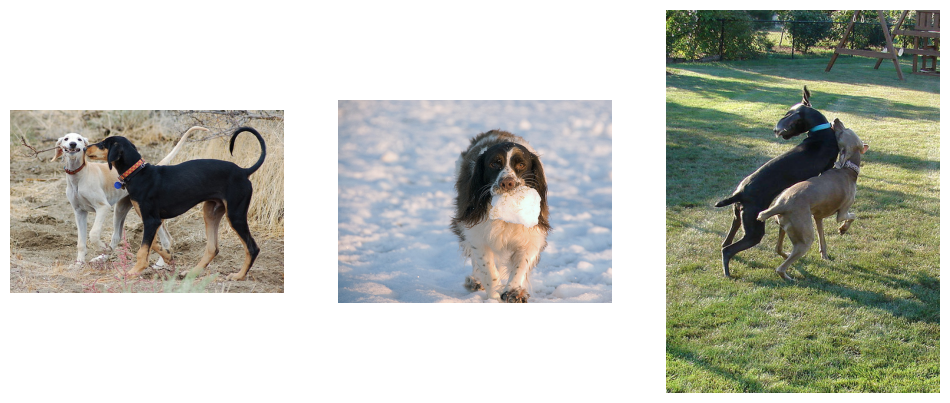

In [ ]:
pred_lr_test('A white dog and a black dog in a field')

## Выводы

Была выбрана лучшая модель линейной регрессии и протестированна на тестовых данных.

В целом, концепция показала свою жизнеспособность, но она нуждается в существенной доработке.

**Возможные направления**:
- Увеличение датасета может существенно улучшить результаты
- Использование более глубокой нейросети с более тщательным подбором гирперпараметров
- Оценки комьюнити не выглядят очень точными и ценными, но они многочислены. Хорошо бы придумать, как их заставить работать на повышение точности моделей